In [1]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# read in air temperature data
filepath = 'cityheat/Bmore/2016/'

meta = pd.DataFrame(pd.read_csv(filepath + 'data/CleanedMeta2016.csv', sep = ','))
meta = meta.set_index('sensornumber', drop = False)
meta = meta.set_index(meta.index.astype(int), drop = False)
#mean_temp = pd.read_csv('meantemp.csv', header=-1).rename(columns = {0: 'SensorNumber', 1:'MeanTemp'}).set_index('SensorNumber')
tempDF = pd.read_csv(filepath + 'data/CleanedTemp2016.csv', parse_dates = [0]).set_index('Date').resample('H').first()
tempDF.columns = tempDF.columns.astype(int)

rhDF = pd.read_csv(filepath + 'data/CleanedRH2016.csv', parse_dates = [0]).set_index('Date').resample('H').first()
rhDF.columns = tempDF.columns.astype(int)

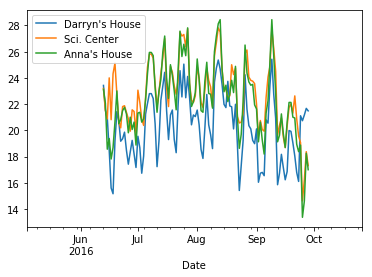

In [3]:
#68 = rural 
#108 = urban
#97 = SC
tempDF[[68, 97,108]].resample('D').min().plot()
plt.legend(['Darryn\'s House', 'Sci. Center','Anna\'s House'])
urban = 97
rural = 68

In [5]:
# read in LST data
import scipy.stats
import ee 
sigma = 5.671e-8 #W.m-2.K-4

ee.Initialize()

def compute_LST(lat,lon, startTime, endTime): 
    L8_DN = ee.ImageCollection('LANDSAT/LC8_L1T').filterDate(startTime, endTime)
    emissivity = ee.Image('NASA/ASTER_GED/AG100_003').select('emissivity_band10').multiply(0.001) 

    k1 = 774.8853 ; # constants for Landsat8 B10
    k2 =  1321.0789 ; # constants for Landsat8 B10
    dummyk1 = emissivity.multiply(0).add(1).multiply(k1) # make dummy variable same size/type as emissivity
    dummyk2 = emissivity.multiply(0).add(1).multiply(k2) # make dummy variable same size/type as emissivity

    point = {'type':'Point', 'coordinates':[lon,lat]};
    L8_DN_point = L8_DN.filterBounds(point)    
    L8_DN_point = L8_DN_point.sort('CLOUD_COVER').first()  

    # select individual bands, assuming Landsat8
    image = ee.Image(L8_DN_point)
    tir = image.select(u'B10') # thermal infrared
    red = image.select(u'B4') # infrared
    nir = image.select(u'B5') # near infrared

    radiance = tir.multiply(3.3420E-04).add(.1)  # scale by gain and bias, band specific 
    L_lamda = radiance.divide(emissivity); # correct for emissivity
    k1_over_L_lamda = dummyk1.divide(L_lamda) 
    denominator = k1_over_L_lamda.add(1).log(); 
    lst = dummyk2.divide(denominator).subtract(273.15); # finally convert to degrees C

    info = ee.ImageCollection(lst).getRegion(point,500).getInfo()
    df = pd.DataFrame(info[1],
                      index = info[0], 
                ).T.rename(columns ={'emissivity_band10': 'LST'})
    df['date'] = L8_DN_point.getInfo()['properties']['DATE_ACQUIRED']
    df['time'] = L8_DN_point.getInfo()['properties']['SCENE_CENTER_TIME']

    df['cloud_cover'] = L8_DN_point.getInfo()['properties']['CLOUD_COVER']
    return df

# def compute_energy_budget(T_a, T_s, epsilon_a = 0.9025) : 
#     q_a = 0.022# needs to be same units as q_star

#     alpha = .3

#     if T_a.max() < 200: 
#         T_a = T_a + 273.15
#         T_s = T_s + 273.15
#     # make sure there is a diurnal range if using vectors
#     R_s = 900
#     S_in = R_s -R_s*np.cos(-.25*(np.arange(0,24)))

#     rho = 1.29 #kg/m, Seinfeld and Pandis
#     cp = 1005 # J/K/kg
#     ra = 60 # m/s B&E
#     beta = 0.5 # sample value, B&E, moisture availability
#     T_bar = 25 # deep ground temperature
#     sigma = 5.671e-8 #W.m-2.K-4
#     L = 2.5e6
#     omega = 1/(12*60*60) # diurnal forcing frequency

#     # humidity
#     #q_a = 14 # mbar specific humidity
#     # from https://woodshole.er.usgs.gov/operations/sea-mat/air_sea-html/qsat.html
#     Pa = 1000
#     ew = 6.1121*(1.0007+3.46e-6*Pa)*np.exp((17.502*(T_s-273.15))/(240.97+(T_s-273.15))) # in mb
#     q  = 0.62197*(ew/(Pa-0.378*ew))      

#     q_star = q # q_star ~ 0.622 es/Pa saturated  spef. humidity at the surface temperature, t_s

#     # emissivity
#     #epsilon_a = 0.7649 # emiss = absorpt. = 1- transmissivity; estimated from ModTran, using water vapor scale of 1 http://climatemodels.uchicago.edu/modtran/modtran.html
#     epsilon_s = .9

#     lw_net = epsilon_a *sigma*T_a**4 - epsilon_s*sigma*T_s**4
#     R_net = (1-alpha)*S_in + epsilon_a *sigma*T_a**4 - epsilon_s*sigma*T_s**4
#     H = rho*cp/ra * (T_s - T_a)
#     LE = -beta*rho*L/ra * (q_star-q_a)
#     G = -omega*(T_s -T_bar)
#     net = R_net + H+ LE + G
#     return R_net, H, LE, G, net, lw_net

def easy_scatter(x,y,title = '', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y, color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

In [6]:
frames = []
startTimes = ['2016-07-01', '2016-07-17', '2016-08-01']
endTimes= ['2016-07-04', '2016-07-19', '2016-08-05']
lon = meta.loc[urban]['location:Longitude']
lat =  meta.loc[urban]['location:Latitude']
for startTime, endTime in zip(startTimes, endTimes): 
    frames.append(compute_LST(lat,lon,startTime, endTime))

df = pd.concat(frames)
df

,id,longitude,latitude,time,LST,date,cloud_cover
0,0,-76.6106,39.2811,15:46:18.5995300Z,34.6858,2016-07-02,0.43
0,0,-76.6106,39.2811,15:46:25.2590230Z,34.9534,2016-07-18,5.89
0,0,-76.6106,39.2811,15:46:28.4215680Z,31.4347,2016-08-03,46.48


In [7]:
frames = []
startTimes = ['2016-07-01', '2016-07-17', '2016-08-01']
endTimes= ['2016-07-04', '2016-07-19', '2016-08-05']
lon = meta.loc[rural]['location:Longitude']
lat =  meta.loc[rural]['location:Latitude']
for startTime, endTime in zip(startTimes, endTimes): 
    frames.append(compute_LST(lat,lon,startTime, endTime))

rural_df = pd.concat(frames)
rural_df

,id,longitude,latitude,time,LST,date,cloud_cover
0,0,-76.7049,39.4787,15:46:18.5995300Z,26.327,2016-07-02,0.43
0,0,-76.7049,39.4787,15:46:25.2590230Z,27.5873,2016-07-18,5.89
0,0,-76.7049,39.4787,15:46:04.5347660Z,24.24,2016-08-03,31.12


In [8]:
df = df.rename(columns={'LST': 'LST_urban'})
df['LST_rural'] = rural_df['LST']
df

,id,longitude,latitude,time,LST_urban,date,cloud_cover,LST_rural
0,0,-76.6106,39.2811,15:46:18.5995300Z,34.6858,2016-07-02,0.43,26.327
0,0,-76.6106,39.2811,15:46:25.2590230Z,34.9534,2016-07-18,5.89,27.5873
0,0,-76.6106,39.2811,15:46:28.4215680Z,31.4347,2016-08-03,46.48,24.24


In [9]:
# read in synoptic Data
file = '/Users/ascott47/blausteinmount/heat/data/synopticclassification/' + 'BWI'+ '.dbdmt'
synopticDF =  pd.read_table(file, sep = ' ', header =  None)
synopticDF.columns = ['id','date', 'ssc']
synopticDF.index = pd.PeriodIndex(synopticDF['date'], freq = 'D', name = 'month_period')
synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5

/Users/ascott47/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [57]:
# synopticDF.loc['2016-07-02']#,  '2016-07-18', '2016-08-03']]
# synopticDF.loc['2016-07-18']
# synopticDF.loc['2016-08-03']
df['ssc'] = [2,6, 4]

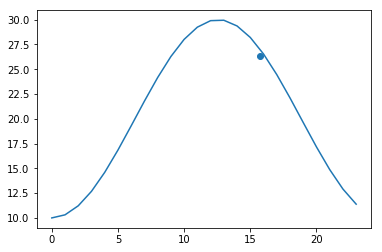

In [10]:
T_s = 20 + 10*np.sin(-.25*(np.arange(0,24))-np.pi/2)

plt.plot(T_s)
plt.scatter(15.75, 26.327)

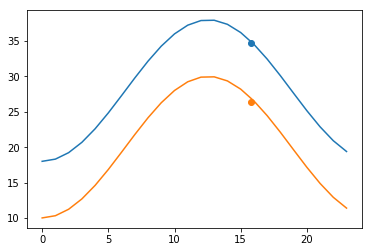

In [68]:
# LST for urban july 2
T_s = 28 + 10*np.sin(-.25*(np.arange(0,24))-np.pi/2)
plt.plot(T_s, label = 'Urban, July 2')
plt.scatter(15.75, 34.6858)

#LST for rural july 2
T_s = 20 + 10*np.sin(-.25*(np.arange(0,24))-np.pi/2)
plt.plot(T_s, label = 'Rural, July 2')
plt.scatter(15.75, 26.327)

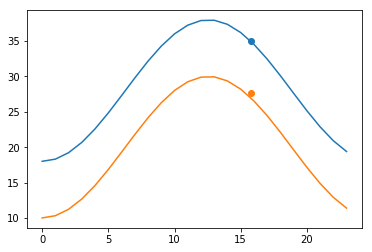

In [69]:
# LST for urban july 18
T_s = 28 + 10*np.sin(-.25*(np.arange(0,24))-np.pi/2)
plt.plot(T_s, label = 'Urban, July 18')
plt.scatter(15.75, 34.9534)

#LST for rural july 18
T_s = 20 + 10*np.sin(-.25*(np.arange(0,24))-np.pi/2)
plt.plot(T_s, label = 'Rural, July 18')
plt.scatter(15.75, 27.5873)

In [64]:
df

,id,longitude,latitude,time,LST_urban,date,cloud_cover,LST_rural,ssc
0,0,-76.6106,39.2811,15:46:18.5995300Z,34.6858,2016-07-02,0.43,26.327,2
0,0,-76.6106,39.2811,15:46:25.2590230Z,34.9534,2016-07-18,5.89,27.5873,6
0,0,-76.6106,39.2811,15:46:28.4215680Z,31.4347,2016-08-03,46.48,24.24,4


In [115]:
def compute_energy_budget(T_a, T_s, rh,  epsilon_a = 0.9025) : 
    q_a = 0.022# needs to be same units as q_star

    alpha = .3

    if T_a.max() < 200: 
        T_a = T_a + 273.15
        T_s = T_s + 273.15
    # make sure there is a diurnal range if using vectors
    R_s = 600
    S_in = R_s -R_s*np.cos(-.25*(np.arange(0,24)))

    rho = 1.29 #kg/m, Seinfeld and Pandis
    cp = 1005 # J/K/kg
    ra = 60 # m/s B&E
    beta = 0.5 # sample value, B&E, moisture availability
    T_bar = 25 # deep ground temperature
    sigma = 5.671e-8 #W.m-2.K-4
    L = 2.5e3
    omega = 1/(12*60*60) # diurnal forcing frequency

    # humidity
    #q_a = 14 # mbar specific humidity
    # from https://woodshole.er.usgs.gov/operations/sea-mat/air_sea-html/qsat.html
    Pa = 1000
#     ew = 6.1121*(1.0007+3.46e-6*Pa)*np.exp((17.502*(T_s))/(240.97+(T_s))) # in mb
#     q_star  = 0.62197*(ew/(Pa-0.378*ew)) # in kg/kg    
#     q_star = q # q_star ~ 0.622 es/Pa saturated  spef. humidity at the surface temperature, t_s

    ew = 6.1121*(1.0007+3.46e-6*Pa)*np.exp((17.502*(T_s))/(240.97+(T_s))) # in mb
    q_star_LST = 0.62197*(ew/(Pa-0.378*ew)) #saturation mixing ratio of water at LST

    # compute q_a
    #rh = rhDF[urban].loc[T_a.index].values.flatten()
    #T_a = T_a.values.flatten()
#     ew = 6.1121*(1.0007+3.46e-6*Pa)*np.exp((17.502*(T_a))/(240.97+(T_a))) # in mb
#     sat_mix_ratio = 0.62197*(ew/(Pa-0.378*ew))
#     mixing_ratio = rh*sat_mix_ratio
#     q_a = mixing_ratio/(1+mixing_ratio)
    
    mixing_ratio = rh2mixr(rh,1013e5, T_a+273.15)
    q_a = mixing_ratio/(1+mixing_ratio)
    
    LE = beta*rho*L/ra * (q_star_LST-q_a)
    # emissivity
    #epsilon_a = 0.7649 # emiss = absorpt. = 1- transmissivity; estimated from ModTran, using water vapor scale of 1 http://climatemodels.uchicago.edu/modtran/modtran.html
    epsilon_s = .9

    lw_net = epsilon_a *sigma*T_a**4 - epsilon_s*sigma*T_s**4
    R_net = (1-alpha)*S_in + epsilon_a *sigma*T_a**4 - epsilon_s*sigma*T_s**4
    H = rho*cp/ra * (T_s - T_a)
    #LE = beta*rho*L/ra * (q_star-q_a)
    G = -omega*(T_s -T_bar)
    net = R_net + H+ LE + G
    return R_net, H, LE, G, net, lw_net

In [71]:
ew = 6.1121*(1.0007+3.46e-6*Pa)*np.exp((17.502*(T_a))/(240.97+(T_a))) # in mb
q_star_air = 0.62197*(ew/(Pa-0.378*ew)) #saturation mixing ratio of water at LST
q_star_air

array([ 0.01786144,  0.01765722,  0.01786144,  0.01799838,  0.01786144,
        0.0169931 ,  0.01679875,  0.0169931 ,  0.01786144,  0.01862677,
        0.01891199,  0.01971583,  0.02047332,  0.02165736,  0.02223139,
        0.02248056,  0.0230739 ,  0.02149597,  0.02133564,  0.02055109,
        0.02009201,  0.01927338,  0.01883975,  0.01806665])

In [80]:
from math import log10,exp

# Description:
# conversions between different humidity quantities

Mw=18.0160 # molecular weight of water
Md=28.9660 # molecular weight of dry air
R =  8.31432E3 # gas constant
Rd = R/Md # specific gas constant for dry air
Rv = R/Mw # specific gas constant for vapour
Lv = 2.5e6 # heat release for condensation of water vapour [J kg-1]
eps = Mw/Md
#saturation pressure
def esat(T):
    ''' get sateration pressure (units [Pa]) for a given air temperature (units [K])'''
    from numpy import log10
    TK = 273.15
    e1 = 101325.0
    logTTK = log10(T/TK)
    esat =  e1*10**(10.79586*(1-TK/T)-5.02808*logTTK+ 1.50474*1e-4*(1.-10**(-8.29692*(T/TK-1)))+ 0.42873*1e-3*(10**(4.76955*(1-TK/T))-1)-2.2195983) 
    return esat
def esat2(T):
    ''' a simpler form for the saturation pressure (units [Pa]) for a given air temperature (units [K]), based on clausius-claperyon'''
    return 611.*exp(-Lv/Rv*(1./T - 1./273.16))

def rh2mixr(RH,p,T):
    '''purpose: conversion relative humidity (unitless) to mixing ratio [kg/kg]'''
    es = esat(T)
    return Mw/Md*RH*es/(p-RH*es)

def mixr2rh(mixr,p,T):
    '''purpose: conversion mixing ratio to relative humidity [kg/kg] (not tested)'''
    return mixr * p/((mixr+Mw/Md)*esat(T))

def mixr2sh(W):
    '''conversion from mixing ratio (units [kg/kg]) to specific humidity (units also [kg/kg])
    '''
    return W/(1.+W)
def sh2mixr(qv):
    '''conversion from specific humidity (units [kg/kg]) to mixing ratio (units also [kg/kg])
    '''
    return qv/(1.-qv)
def ea2mixr(P,ea):
    '''conversion from dry air and vapour pressure (units [Pa]) to mixing ratio (units [kg/kg]) 
    '''
    return 0.622*ea/(P-ea)
def mixr2ea(P,mixr):
    '''conversion from dry air pressure (units [Pa]) and mixing ratio (units [kg/kg] to vapour pressure (units [Pa])
    '''
    return P*mixr/(0.622+ea)

def ah2mixr (rhov,p,T):
    '''conversion from absolute humidity (units [kg/m**3]) to mixing ratio (units also [kg/kg])
       not tested
    '''
    return (Rd * T)/(p/rhov-Rv*T)

# not tested
def wvap2sh(e,p):
    '''conversion from water vapour pressure (units [Pa]) to specific humidity (units [kg/kg]) 
    '''
    return eps*e/(p-(1.-eps)*e)

def rh2ah(RH,p,T):
    '''conversion relative humidity to absolute humidity (kg Water per m^3 Air)'''
    mixr=rh2mixr(RH, p,T)
    sh=mixr2sh(mixr)
    return  sh*rhov(T,p,sh) 

In [113]:
T_a= tempDF[[urban]]['2016-07-02']
rh = rhDF[urban].loc[T_a.index]

mixr = rh2mixr(rh.values.flatten(),1013e5, T_a.values.flatten()+273.15)
mixr

array([ 0.0015195 ,  0.0015112 ,  0.00133364,  0.00112634,  0.00106712,
        0.00107354,  0.00104239,  0.00100598,  0.00096388,  0.00086103,
        0.00081678,  0.00082706,  0.00082078,  0.00073295,  0.0007661 ,
        0.00077458,  0.00076575,  0.00080817,  0.00081544,  0.00083652,
        0.00080567,  0.00083223,  0.0008022 ,  0.00086794])

In [ ]:
T = 
TK = 273.15
e1 = 101325.0
logTTK = log10(T/TK)
esat =  e1*10**(10.79586*(1-TK/T)-5.02808*logTTK+ 1.50474*1e-4*(1.-10**(-8.29692*(T/TK-1)))+ 0.42873*1e-3*(10**(4.76955*(1-TK/T))-1)-2.2195983) 

mixing_ratio = Mw/Md*RH*es/(p-RH*es)

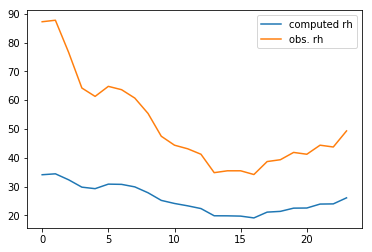

In [79]:
plt.plot(q_a/q_star_air, label = 'computed rh')
plt.plot(rh, label = 'obs. rh')
plt.legend()

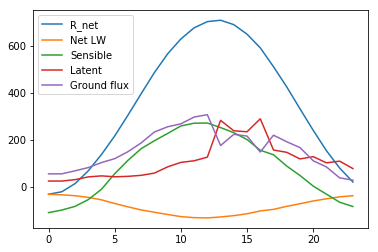

In [116]:
T_a= tempDF[[urban]]['2016-07-02']#20 + 8*np.sin(-.25*(np.arange(0,24)+ 3.14))
T_s = 28 + 10*np.sin(-.25*(np.arange(0,24))-np.pi/2)

epsilon_a = 1-0.2351 # emiss = absorpt. = 1- transmissivity; estimated from ModTran, using water vapor scale of 1 http://climatemodels.uchicago.edu/modtran/modtran.html
R_net, H, LE, G, net, lw_net = compute_energy_budget(np.array(T_a.T.values)[0], T_s, 
                                                     rhDF[urban].loc[T_a.index].values.flatten(), 
                                                     epsilon_a)
handle = plt.plot(np.arange(0,24), R_net, 
        np.arange(0,24), lw_net,
        np.arange(0,24), H, 
        np.arange(0,24), LE, 
        np.arange(0,24), R_net - H -LE, 
        #np.arange(0,24), net, '--k',
        )
plt.legend(['R_net', 'Net LW','Sensible', 'Latent', 'Ground flux', 'Net'])


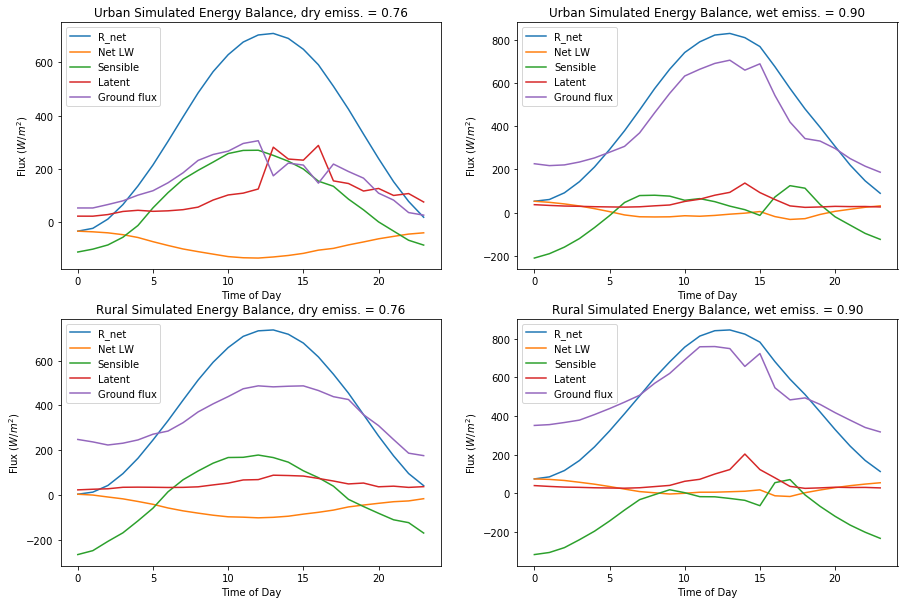

In [117]:
# Compute dry energy budget 
## Urban
T_a= tempDF[[urban]]['2016-07-02']#20 + 8*np.sin(-.25*(np.arange(0,24)+ 3.14))
T_s = 28 + 10*np.sin(-.25*(np.arange(0,24))-np.pi/2)
rh = rhDF[urban]['2016-07-02']

fig = plt.figure(figsize = [15,10])
plt.subplot(2,2,1)

epsilon_a = 1-0.2351 # emiss = absorpt. = 1- transmissivity; estimated from ModTran, using water vapor scale of 1 http://climatemodels.uchicago.edu/modtran/modtran.html
R_net, H, LE, G, net, lw_net = compute_energy_budget(np.array(T_a.T.values)[0], T_s, rh.values.flatten(), epsilon_a)
plt.plot(np.arange(0,24), R_net, 
        np.arange(0,24), lw_net,
        np.arange(0,24), H, 
        np.arange(0,24), LE, 
        np.arange(0,24), R_net - H -LE, 
        #np.arange(0,24), net, '--k',
        )
plt.xlabel('Time of Day')
plt.ylabel('Flux ($W/m^2$)')
plt.legend(['R_net', 'Net LW','Sensible', 'Latent', 'Ground flux', 'Net'])
plt.title('Urban Simulated Energy Balance, dry emiss. = %2.2f'%epsilon_a)

# Compute the moist energy budget
T_a= tempDF[[urban]]['2016-07-18']#20 + 8*np.sin(-.25*(np.arange(0,24)+ 3.14))
rh = rhDF[urban]['2016-07-18']

plt.subplot(2,2,2)
epsilon_a = 1-0.0975 # 'wet' emiss = absorpt. = 1- transmissivity; estimated from ModTran, using water vapor scale of 2 http://climatemodels.uchicago.edu/modtran/modtran.html
R_net, H, LE, G, net, lw_net = compute_energy_budget(np.array(T_a.T.values)[0], T_s, rh.values.flatten(), epsilon_a)
plt.plot(np.arange(0,24), R_net, 
        np.arange(0,24), lw_net,
        np.arange(0,24), H, 
        np.arange(0,24), LE, 
        np.arange(0,24), R_net - H -LE, 
        #np.arange(0,24), net, '--k',
        )
plt.xlabel('Time of Day')
plt.ylabel('Flux ($W/m^2$)')
plt.legend(['R_net', 'Net LW','Sensible', 'Latent', 'Ground flux'])
plt.title('Urban Simulated Energy Balance, wet emiss. = %2.2f'%epsilon_a)

## Rural 
T_a= tempDF[[rural]]['2016-07-02']#20 + 8*np.sin(-.25*(np.arange(0,24)+ 3.14))
T_s = 20 + 10*np.sin(-.25*(np.arange(0,24))-np.pi/2)
rh = rhDF[rural]['2016-07-02']

# Compute dry energy budget 
plt.subplot(2,2,3)
epsilon_a = 1-0.2351 # emiss = absorpt. = 1- transmissivity; estimated from ModTran, using water vapor scale of 1 http://climatemodels.uchicago.edu/modtran/modtran.html
R_net, H, LE, G, net, lw_net = compute_energy_budget(np.array(T_a.T.values)[0], T_s, rh.values.flatten(), epsilon_a)
plt.plot(np.arange(0,24), R_net, 
        np.arange(0,24), lw_net,
        np.arange(0,24), H, 
        np.arange(0,24), LE, 
        np.arange(0,24), R_net - H -LE, 
        #np.arange(0,24), net, '--k',
        )
plt.xlabel('Time of Day')
plt.ylabel('Flux ($W/m^2$)')
plt.legend(['R_net', 'Net LW','Sensible', 'Latent', 'Ground flux', ])
plt.title('Rural Simulated Energy Balance, dry emiss. = %2.2f'%epsilon_a)

# Compute the moist energy budget
T_a= tempDF[[rural]]['2016-07-18']#20 + 8*np.sin(-.25*(np.arange(0,24)+ 3.14))
rh = rhDF[urban]['2016-07-18']

plt.subplot(2,2,4)
epsilon_a = 1-0.0975 # 'wet' emiss = absorpt. = 1- transmissivity; estimated from ModTran, using water vapor scale of 2 http://climatemodels.uchicago.edu/modtran/modtran.html
R_net, H, LE, G, net, lw_net = compute_energy_budget(np.array(T_a.T.values)[0], T_s, rh.values.flatten(), epsilon_a)
plt.plot(np.arange(0,24), R_net, 
        np.arange(0,24), lw_net,
        np.arange(0,24), H, 
        np.arange(0,24), LE, 
        np.arange(0,24), R_net - H -LE, 
        #np.arange(0,24), net, '--k',
        )
plt.xlabel('Time of Day')
plt.ylabel('Flux ($W/m^2$)')

plt.legend(['R_net', 'Net LW','Sensible', 'Latent', 'Ground flux'])
plt.title('Rural Simulated Energy Balance, wet emiss. = %2.2f'%epsilon_a)

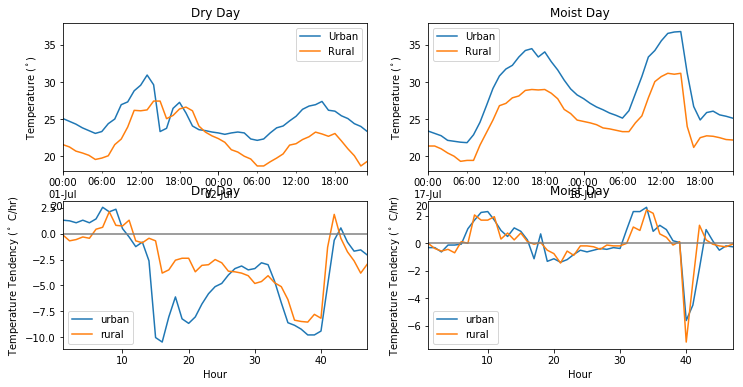

In [118]:
plt.figure(figsize=[12,6])
# plot temperature 
ax = plt.subplot(221)
tempDF[[urban, rural]]['2016-07-01':'2016-07-02'].plot(ax = ax)
plt.legend(['Urban', 'Rural'])
plt.title('Dry Day')
plt.ylim([18,38])
plt.ylabel('Temperature ($^\circ$)')

ax2 = plt.subplot(222)
tempDF[[urban, rural]]['2016-07-17':'2016-07-18'].plot(ax = ax2)
plt.legend(['Urban', 'Rural'])
plt.title('Moist Day')
plt.ylim([18,38])
plt.ylabel('Temperature ($^\circ$)')

# plot temp tendency
ax3 = plt.subplot(223)
dT = pd.DataFrame(tempDF[[urban, rural]]['2016-07-01':'2016-07-02'].iloc[1:,:].values - tempDF[[urban, rural]]['2016-07-17':'2016-07-18'].iloc[0:-1,:].values, 
            columns = ['urban', 'rural'], index = np.arange(1,48))
dT.plot(ax = ax3)
plt.axhline(0, color = 'grey')
plt.xlabel('Hour')
plt.ylabel('Temperature Tendency ($^\circ$ C/hr)')
plt.title('Dry Day')

ax4 = plt.subplot(224)
dT = pd.DataFrame(tempDF[[urban, rural]]['2016-07-17':'2016-07-18'].iloc[1:,:].values - tempDF[[urban, rural]]['2016-07-17':'2016-07-18'].iloc[0:-1,:].values, 
            columns = ['urban', 'rural'], index = np.arange(1,48))
dT.plot(ax = ax4)
plt.axhline(0, color = 'grey')

plt.xlabel('Hour')
plt.ylabel('Temperature Tendency ($^\circ$ C/hr)')
plt.title('Moist Day')

In [119]:
rho = 1
epsilon_s = .9
dT_model = epsilon_s*sigma*T_s**4 - 2*epsilon_a*sigma*T_a.values.flatten()**4
dT_model

array([-0.03740482, -0.03619573, -0.03448337, -0.03149485, -0.02981427,
       -0.02701149, -0.0230723 , -0.01865282, -0.01937877, -0.01838936,
       -0.03021893, -0.04606498, -0.0504897 , -0.05556764, -0.05709772,
       -0.06428357, -0.00855048, -0.00227993, -0.01395769, -0.0197638 ,
       -0.02260218, -0.02364872, -0.02358266, -0.02386572])

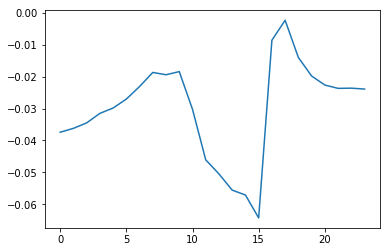

In [120]:
plt.plot(dT_model)

(-0.3085669032561858, -0.40857399451669435, 1.2485493425680704e-05)

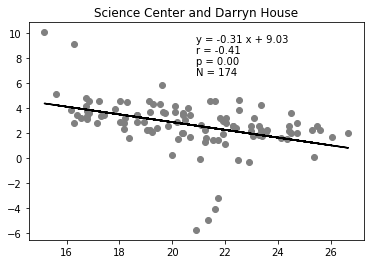

In [121]:
#plt.figure(figsize = [10,5])
#plt.subplot(1,2,1)
UHI = (tempDF[urban][tempDF.index.hour ==6 ] - tempDF[rural][tempDF.index.hour ==6 ])
#UHI = (tempDF[urban].resample('D').min() - tempDF[rural].resample('D').min())
easy_scatter(tempDF[rural][tempDF.index.hour ==6 ],
             UHI, 'Science Center and Darryn House')

# plt.subplot(1,2,2)
# UHI = (tempDF[97].resample('D').min() - tempDF[rural].resample('D').min())
# easy_scatter(tempDF[rural].resample('D').min(), UHI, 'Science Center and Darryn House')

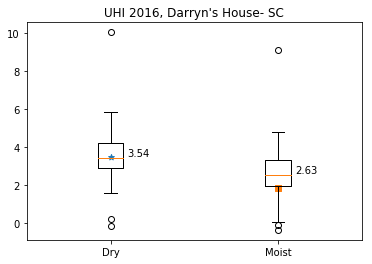

In [122]:
# read in synoptic Data
# file = '/Users/ascott47/blausteinmount/heat/data/synopticclassification/' + 'BWI'+ '.dbdmt'
# synopticDF =  pd.read_table(file, sep = ' ', header =  None, parse_dates = [1])
# synopticDF.columns = ['id','date', 'ssc']
# synopticDF = synopticDF.set_index(synopticDF['date'])
# synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5

# syn = synopticDF['ssc']['2016-06-01': '2016-09-15'].resample('D').mean()#[pd.PeriodIndex(UHI.index, freq = 'D')[0]:pd.PeriodIndex(UHI.index, freq = 'D')[-1]]

UHI = (tempDF[urban][tempDF.index.hour ==6 ] - tempDF[rural][tempDF.index.hour ==6 ]).resample('D').mean()
dry_UHI = UHI[syn[syn <=3].index].dropna()
moist_UHI = UHI[syn[syn > 3].index].dropna()
data = [dry_UHI.values, 
        moist_UHI.values]
fig,ax = plt.subplots()
plot_handle = plt.boxplot(data)
ax.set_xticklabels(['Dry', 'Moist'])
plt.text(1.1, dry_UHI.mean(), '%2.2f'%dry_UHI.mean())
plt.text(2.1, moist_UHI.mean(), '%2.2f'%moist_UHI.mean())
ax.set_title('UHI 2016, Darryn\'s House- SC')

plt.scatter(1, UHI['2016-07-02'], marker='*')
plt.scatter(2, UHI['2016-07-18'], marker='s')

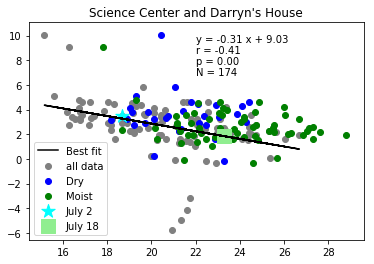

In [264]:
UHI = (tempDF[urban][tempDF.index.hour ==6 ] - tempDF[rural][tempDF.index.hour ==6 ])
easy_scatter(tempDF[rural][tempDF.index.hour ==6 ],
             UHI, 'Science Center and Darryn\'s House')
plt.scatter(tempDF.loc[dry_UHI.index][rural], 
           UHI.resample('D').mean().loc[dry_UHI.index], color = 'blue')
plt.scatter(tempDF.loc[moist_UHI.index][rural], 
           UHI.resample('D').mean().loc[moist_UHI.index], color = 'green')

plt.scatter(tempDF[rural]['2016-07-02 06:00:00'], UHI['2016-07-02'], s=200, marker = '*', color = 'cyan')
plt.scatter(tempDF[rural]['2016-07-18 06:00:00'], UHI['2016-07-18'], s=200, marker = 's', color = 'lightgreen')
#plt.scatter(tempDF[rural]['2016-08-03 06:00:00'], UHI['2016-08-03'], s=200, marker = 's', color = 'pink')

plt.legend(['Best fit', 'all data', 'Dry', 'Moist', 'July 2', 'July 18', 'Aug 3'], loc = 3)

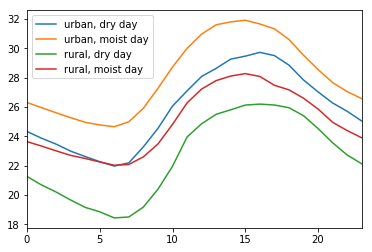

In [195]:
# frames = []
# for date in syn[syn<=3].index: 
#     frames.append(tempDF[tempDF.index.date==date.to_datetime().date()])
    
# dry_tempDF = pd.concat(frames)

# frames = []
# for date in syn[syn>3].index: 
#     frames.append(tempDF[tempDF.index.date==date.to_datetime().date()])
    
# moist_tempDF = pd.concat(frames)
dry_tempDF.groupby(dry_tempDF.index.hour).mean()[urban].plot(label= 'urban, dry day')
moist_tempDF.groupby(moist_tempDF.index.hour).mean()[urban].plot(label= 'urban, moist day')
dry_tempDF.groupby(dry_tempDF.index.hour).mean()[rural].plot(label= 'rural, dry day')
moist_tempDF.groupby(moist_tempDF.index.hour).mean()[rural].plot(label= 'rural, moist day')
plt.legend()

# to do: 
- ground check LST daily cycle 
- incoporate actual radiation data
- check signs of terms

In [314]:
plt.boxplot?